In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ember-2017-v2-features/train_ember_2017_v2_features.parquet
/kaggle/input/ember-2017-v2-features/test_ember_2017_v2_features.parquet


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, recall_score, precision_score, f1_score, accuracy_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

In [3]:
df_train = pd.read_parquet('/kaggle/input/ember-2017-v2-features/train_ember_2017_v2_features.parquet')
df_test = pd.read_parquet('/kaggle/input/ember-2017-v2-features/test_ember_2017_v2_features.parquet')

In [4]:
df_train.Label.value_counts()

Label
 0.0    299992
-1.0    299973
 1.0    299793
Name: count, dtype: int64

In [5]:
df_train = df_train[df_train['Label'].isin([0,1])]

In [6]:
df_train.Label.value_counts()

Label
0.0    299992
1.0    299793
Name: count, dtype: int64

In [7]:
df_test.Label.value_counts()

Label
0.0    99996
1.0    99984
Name: count, dtype: int64

In [8]:
def xs_y(df_, targ): 
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy()
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y

In [9]:
target = 'Label'

In [10]:
X_train, y_train = xs_y(df_train, targ=target)
X_test, y_test = xs_y(df_test, targ=target)

In [11]:
import gc
del [[df_train, df_test]]
gc.collect()
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [12]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='gini', max_depth=1, class_weight='balanced'), n_estimators=50, learning_rate=1.0)

In [13]:
ada.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=1))

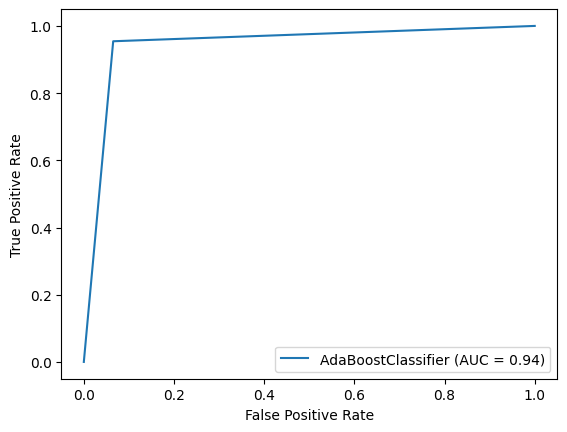

In [14]:
fpr, tpr, thresholds = roc_curve(y_train, ada.predict(X_train))
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='AdaBoostClassifier')
display.plot()

In [15]:
ada_preds = ada.predict(X_test)                   
print(ada_preds.shape)
print(best_thresh)

(199980,)
1.0


In [16]:
print("The final Adaboost results")
print("ROC-AUC", round(roc_auc_score(y_true=y_test, y_score=ada_preds),4))
print("Precision", round(precision_score(y_true=y_test, y_pred=np.where(ada_preds >= best_thresh, 1, 0)), 4))
print("Recall", round(recall_score(y_true=y_test, y_pred=np.where(ada_preds >= best_thresh, 1, 0)), 4))
print("F1", round(f1_score(y_true=y_test, y_pred=np.where(ada_preds >= best_thresh, 1, 0)), 4))

The final Adaboost results
ROC-AUC 0.9473
Precision 0.9492
Recall 0.9451
F1 0.9472
